# Fluorescence Recovery After Photobleaching

In [1]:
#importing the required modules
import numpy as np #Numerical Python
import scipy #Scientific Python
from scipy.optimize import leastsq #for least squares fitting

%matplotlib notebook

import matplotlib
from matplotlib import pylab

#For making interactive user interfaces (buttons and sliders and such)
import ipywidgets as widgets
from ipywidgets import Layout, interact, fixed

#Loading the particle tracking software
import sys
import tiff_file #Ignore any warnings importing this may cause

tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


## Specify location of data

In [2]:
#Now let's locate the data
data_directory = ".\\for_frap\\"
data_file = "2019_01_24_S1_FRAP_08.tif"

## Identify where bleaching occurs

<IPython.core.display.Javascript object>


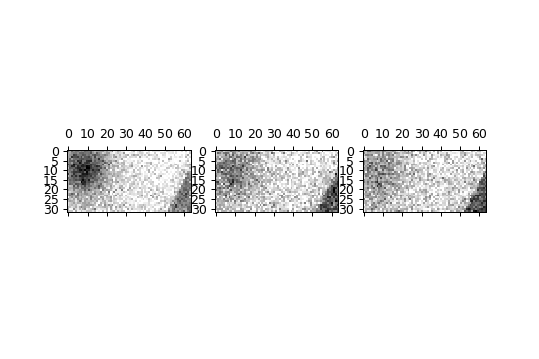

(1283L, 32L, 64L)


In [3]:
first_postbleach_frame = 17 #start counting at frame=0
all_frames = tiff_file.imread(data_directory+data_file)
postbleach_frame = all_frames[first_postbleach_frame]
fig,ax = pylab.subplots(1,3,figsize=(6,4))
ax[0].matshow(postbleach_frame,cmap=matplotlib.cm.gray, interpolation=None)
ax[1].matshow(all_frames[first_postbleach_frame+200],cmap=matplotlib.cm.gray, interpolation=None)
ax[2].matshow(all_frames[first_postbleach_frame+400],cmap=matplotlib.cm.gray, interpolation=None)


print all_frames.shape

<IPython.core.display.Javascript object>


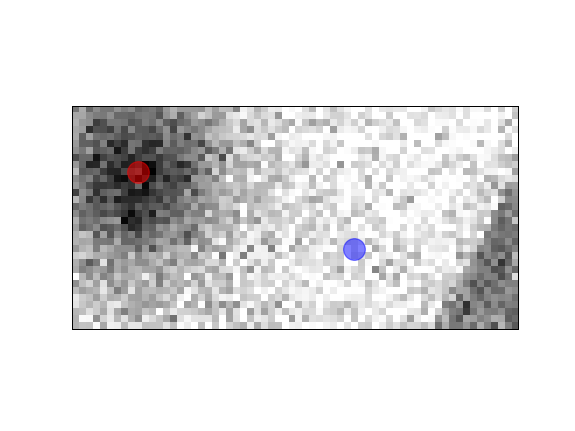

[]

In [4]:
#Choose coordinates of the *center* of a bleached region
y_center_bleach = 9  # <------ you will need to change this for your data!
x_center_bleach = 9  # <------ you will need to change this for your data!

#Choose coordinates of the *center* of some background region
y_center_bg = 20   # <------ you will need to change this for your data
x_center_bg = 40# <------ you will need to change this for your data

#Plotting just to make sure the coordinates above are appropriate
fig,ax = pylab.subplots()
ax.invert_yaxis()
ax.matshow(postbleach_frame,cmap=matplotlib.cm.gray, interpolation=None)
ax.scatter(x_center_bleach, y_center_bleach, s=300, alpha=0.5, c='r') #Red circle in bleach area
ax.scatter(x_center_bg, y_center_bg, s=300, alpha=0.5, c='b') #Blue circle outside bleach region

ax.set_xticks([])
ax.set_yticks([])


In [34]:
font = {'family' : 'serif',
        'weight' : 'light',  #Or 'normal' or 'bold'
        'size'   : 11}

matplotlib.rc('font', **font)

## For finding colors:
##    https://color.adobe.com/create/color-wheel

<IPython.core.display.Javascript object>


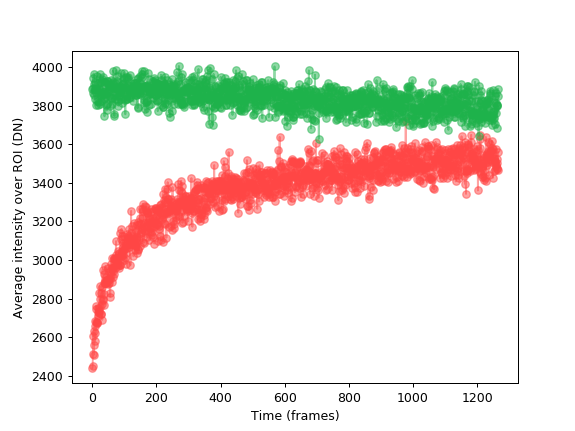

<IPython.core.display.Javascript object>


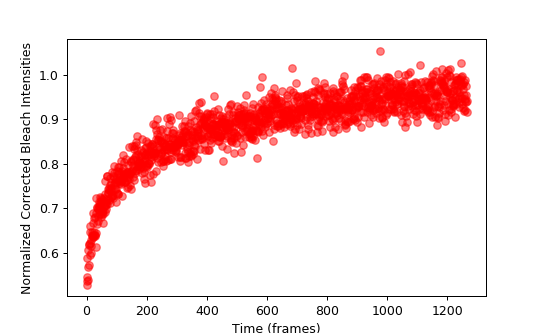

Text(0,0.5,'Normalized Corrected Bleach Intensities')

In [5]:
roi_size = 4

background_val = 1000

roi_bleach = np.array([[x_center_bleach-roi_size/2, x_center_bleach+roi_size/2],
                       [y_center_bleach-roi_size/2, y_center_bleach+roi_size/2]])
intensity_bleach_roi = all_frames[first_postbleach_frame:, 
                                  roi_bleach[1][0]:roi_bleach[1][1], 
                                  roi_bleach[0][0]:roi_bleach[0][1]].mean(axis=-1).mean(axis=-1)
pre_bleach_intensity = all_frames[:first_postbleach_frame, 
                                 roi_bleach[1][0]:roi_bleach[1][1], 
                                 roi_bleach[0][0]:roi_bleach[0][1]].mean()

roi_bg = np.array([[x_center_bg-roi_size/2, x_center_bg+roi_size/2],
                   [y_center_bg-roi_size/2, y_center_bg+roi_size/2]])
intensity_bg_roi = all_frames[first_postbleach_frame:,
                              roi_bg[1][0]:roi_bg[1][1], 
                              roi_bg[0][0]:roi_bg[0][1]].mean(axis=-1).mean(axis=-1)
pre_bg_intensity = all_frames[:first_postbleach_frame,
                              roi_bg[1][0]:roi_bg[1][1], 
                              roi_bg[0][0]:roi_bg[0][1]].mean()


BL_corr1A = (intensity_bleach_roi - background_val) / (intensity_bg_roi - background_val)
BL_corr2A = BL_corr1A / (pre_bleach_intensity / pre_bg_intensity)

fig,ax = pylab.subplots()
ax.plot(intensity_bleach_roi,'#FF4645',marker='o',alpha=0.5)
ax.plot(intensity_bg_roi,'#1EB24B',marker='o',alpha=0.5)
ax.set_xlabel("Time (frames)")
ax.set_ylabel("Average intensity over ROI (DN)")


fig,ax = pylab.subplots(figsize=(6,6/1.618))
ax.plot(BL_corr2A,'ro',alpha=0.5)
ax.set_xlabel("Time (frames)")
ax.set_ylabel("Normalized Corrected Bleach Intensities")



In [8]:
def expFunc(params, time):
    return params[1]*(1-np.exp(-1.0*time/params[0])) + params[2]

def errorFunc(params, time, data):
    return data-expFunc(params,time)

[265.80870836   0.30198025   0.64517748]


<IPython.core.display.Javascript object>


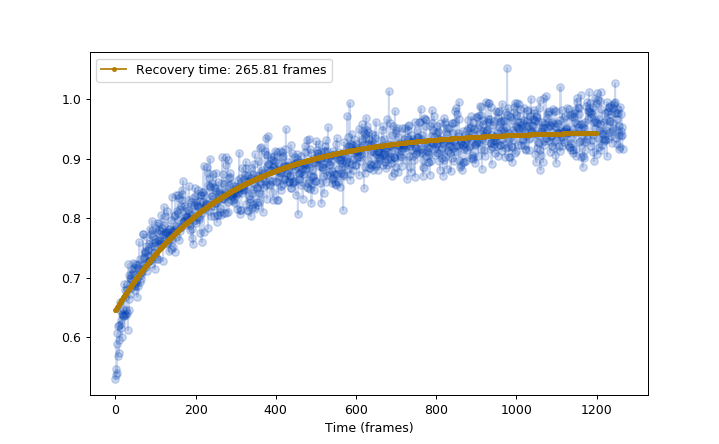

Text(0.5,0,'Time (frames)')

In [9]:
upperLimit = 1200

bestFitA,flat = leastsq(errorFunc, [260,0.5,0.4], args=(np.arange(1,len(BL_corr2A[:upperLimit])+1),BL_corr2A[:upperLimit]))

print bestFitA

fig,ax = pylab.subplots(figsize=(8,8./1.618))
times = np.arange(1200)

ax.plot(BL_corr2A,'#003EB2',marker='o',alpha=0.2)
ax.plot(times, expFunc(bestFitA,times),'#B27B00',marker='.',alpha=0.9,label="Recovery time: %.2f frames" % bestFitA[0])
ax.legend(loc=0)
ax.set_xlabel("Time (frames)")

[265.80870836   0.30198025   0.64517748]


<IPython.core.display.Javascript object>


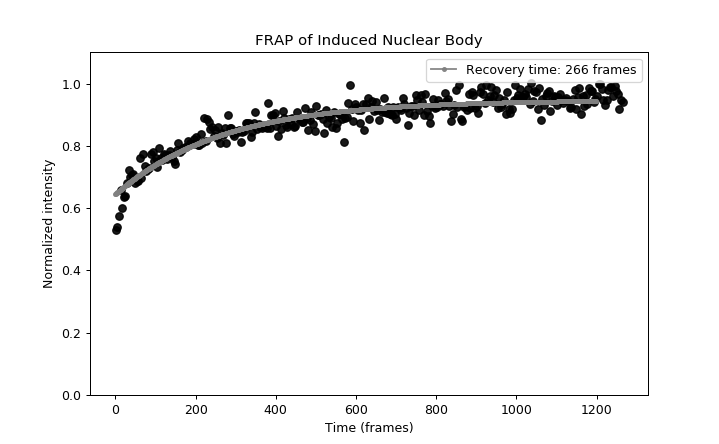

In [10]:
upperLimit = 1200

bestFitA,flat = leastsq(errorFunc, [260,0.5,0.4], args=(np.arange(1,len(BL_corr2A[:upperLimit])+1),BL_corr2A[:upperLimit]))

print bestFitA

fig,ax = pylab.subplots(figsize=(8,8./1.618))
times = np.arange(1200)

ax.plot(np.arange(1,len(BL_corr2A)+1)[::4],BL_corr2A[::4],'0.0',marker='o',alpha=0.9,linestyle='')
ax.plot(times, expFunc(bestFitA,times),'0.5',marker='.',alpha=0.9,label="Recovery time: %.0f frames" % bestFitA[0])
ax.legend(loc=0)
ax.set_xlabel("Time (frames)")
ax.set_ylabel("Normalized intensity")
ax.set_ylim(0,1.1)
ax.set_title("FRAP of Induced Nuclear Body")
pylab.savefig("FRAP_demo.svg")